In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.cross_validation import StratifiedKFold
from sklearn.metrics import roc_curve, auc
from scipy import interp
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split

In [2]:
data = pd.read_csv('sTEF.csv',parse_dates=['signup_date','bgc_date','vehicle_added_date','first_completed_date'],
                   infer_datetime_format=True)

In [3]:
data.shape

(54681, 11)

#### Exploratory Data Analysis

In [4]:
# ASSUMPTION: NaN against first_completed_date is assumed to indicate the driver never took their first trip.
data['started_driving'] = ~data.first_completed_date.isnull()

In [5]:
data.head(n=10)

,id,city_name,signup_os,signup_channel,signup_date,bgc_date,vehicle_added_date,vehicle_make,vehicle_model,vehicle_year,first_completed_date,started_driving
0,1,Strark,ios web,Paid,2016-01-02,NaT,NaT,NaN,NaN,NaN,NaT,False
1,2,Strark,windows,Paid,2016-01-21,NaT,NaT,NaN,NaN,NaN,NaT,False
2,3,Wrouver,windows,Organic,2016-01-11,2016-01-11,NaT,NaN,NaN,NaN,NaT,False
3,4,Berton,android web,Referral,2016-01-29,2016-02-03,2016-02-03,Toyota,Corolla,2016.0,2016-02-03,True
4,5,Strark,android web,Referral,2016-01-10,2016-01-25,2016-01-26,Hyundai,Sonata,2016.0,NaT,False
5,6,Strark,android web,Referral,2016-01-18,2016-01-18,2016-01-22,Cadillac,DTS,2006.0,NaT,False
6,7,Strark,ios web,Paid,2016-01-14,2016-01-16,2016-01-21,Toyota,Prius V,2014.0,2016-01-23,True
7,8,Strark,ios web,Referral,2016-01-26,2016-02-05,NaT,NaN,NaN,NaN,NaT,False
8,9,Strark,NaN,Referral,2016-01-05,NaT,NaT,NaN,NaN,NaN,NaT,False
9,10,Berton,ios web,Paid,2016-01-25,NaT,NaT,NaN,NaN,NaN,NaT,False


In [6]:
for col in data.columns:
    num_null = sum(data[col].isnull())
    print 'Number of null values in col:%s - %d'%(col,num_null)

Number of null values in col:id - 0
Number of null values in col:city_name - 0
Number of null values in col:signup_os - 6857
Number of null values in col:signup_channel - 0
Number of null values in col:signup_date - 0
Number of null values in col:bgc_date - 21785
Number of null values in col:vehicle_added_date - 41547
Number of null values in col:vehicle_make - 41458
Number of null values in col:vehicle_model - 41458
Number of null values in col:vehicle_year - 41458
Number of null values in col:first_completed_date - 48544
Number of null values in col:started_driving - 0


In [7]:
# Since signup_date has no NULL values and in order to find total number of drivers who signed up, we will just use number
# of rows in the data set.
fraction_first_trips = sum(data.started_driving)*1./data.shape[0]
print fraction_first_trips

0.112232768238


##### Answer 1: The percentage of drivers who signed and took their first ride is 11.22%

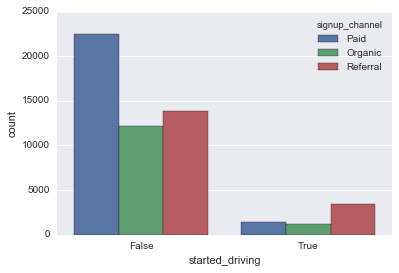

In [8]:
sns.countplot(x="started_driving", hue="signup_channel", data=data);

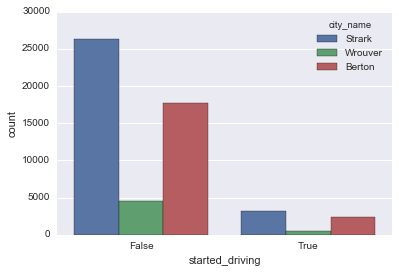

In [9]:
sns.countplot(x="started_driving", hue="city_name", data=data);

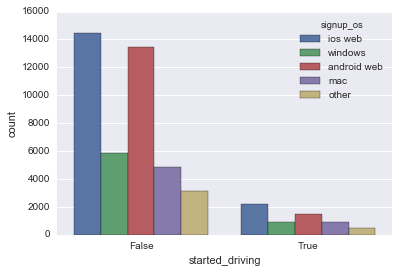

In [10]:
sns.countplot(x="started_driving", hue="signup_os", data=data);

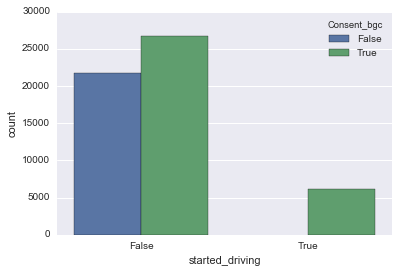

In [11]:
# See if there is any correlation b/w giving consent to bgc and first drive
data['Consent_bgc'] = ~data.bgc_date.isnull()

sns.countplot(x="started_driving", hue="Consent_bgc", data=data);

In [12]:
def boxplots(column):
    date_signup_col = (data[column] - data.signup_date).dt.days

    mask_driving = data.started_driving
    date_signup_col_driving = date_signup_col[mask_driving]
    date_signup_col_notdriving = date_signup_col[~mask_driving]

    signup_col_driving = pd.DataFrame({'signup_to_col_days':date_signup_col_driving})
    signup_col_driving['driving'] = 'Yes'
    signup_col_notdriving = pd.DataFrame({'signup_to_col_days':date_signup_col_notdriving})
    signup_col_notdriving['driving'] = 'No'
    signup_col_notdriving.dropna(inplace=1)

    signup_col = pd.concat((signup_col_driving,signup_col_notdriving),axis=0)

    sns.set(style="ticks", palette="muted", color_codes=True)

    # Plot the orbital period with horizontal boxes
    ax = sns.boxplot(x="signup_to_col_days", y="driving", data=signup_col, color='r')
    # Add in points to show each observation
    sns.stripplot(x="signup_to_col_days", y="driving", data=signup_col, jitter=True, size=3, color=".3", linewidth=0)
    ax.set(xlabel='signup_to_' + column + ' in days')
    sns.despine(trim=True)
    print date_signup_col_driving.quantile(0.9)

9.0


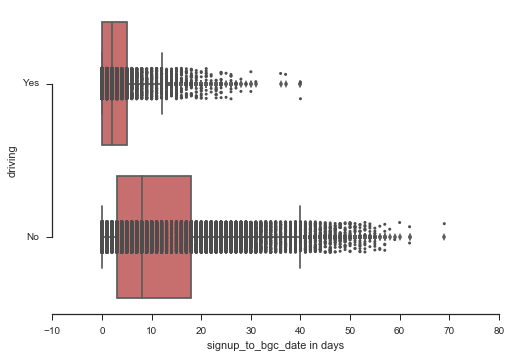

In [13]:
boxplots('bgc_date')

In [14]:
data['vehicle_details_added'] = ~data.vehicle_added_date.isnull()

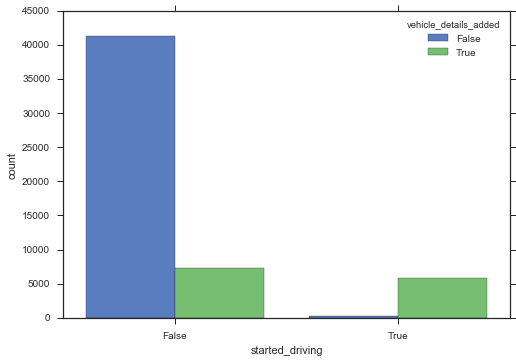

In [15]:
sns.countplot(x='started_driving',hue='vehicle_details_added',data=data)

15.0


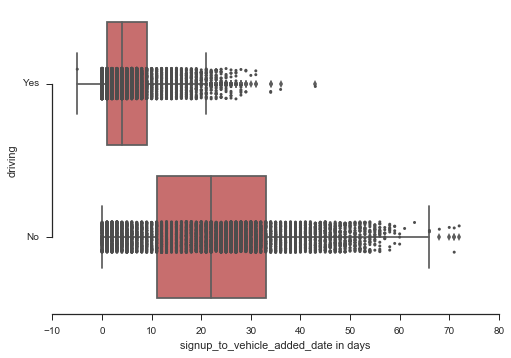

In [16]:
boxplots('vehicle_added_date')

In [17]:
data.vehicle_year.value_counts()

2015.0    2402
2014.0    1655
2013.0    1451
2016.0    1150
2012.0    1122
2007.0     711
2011.0     702
2008.0     659
2010.0     645
2006.0     550
2009.0     513
2005.0     450
2004.0     369
2003.0     350
2002.0     251
2001.0     169
2000.0      29
1999.0      14
1998.0      10
1997.0       6
2017.0       6
1996.0       4
0.0          4
1995.0       1
Name: vehicle_year, dtype: int64

In [18]:
data = data[~(data.vehicle_year == 0.0)]

In [19]:
grouped_by_years = data[['vehicle_year','started_driving']].groupby(by=['vehicle_year',
                                                                        'started_driving']).agg({'started_driving':'count'})
grouped_by_years.columns = ['count']

In [20]:
grouped_by_years.head(n=10)

count
vehicle_year started_driving       
1995.0       False                1
1996.0       False                4
1997.0       False                6
1998.0       False                9
             True                 1
1999.0       False               14
2000.0       False               27
             True                 2
2001.0       False              109
             True                60

In [21]:
def findRatio(grouped_data):
    unique_values = grouped_data.index.levels[0].values
    value_ratios = {}
    for value in unique_values:
        try:
            denom = grouped_data.ix[value].ix[False].values
        except KeyError:
            denom = 1
        try:
            numer = grouped_data.ix[value].ix[True].values
        except KeyError:
            numer = 0
        value_ratios[value] = numer*1./denom    
    return value_ratios

In [22]:
year_ratios = findRatio(grouped_by_years)

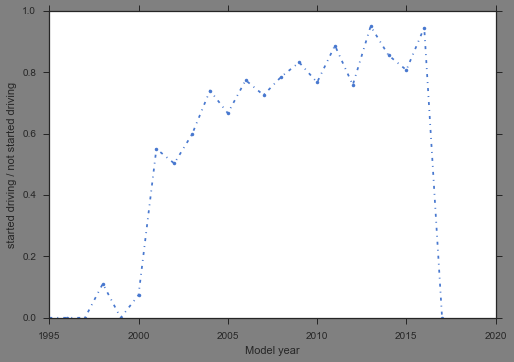

In [23]:
fig=plt.figure(facecolor='grey')
plt.plot(year_ratios.keys(),year_ratios.values(),'.-.')
plt.xlabel('Model year')
plt.ylabel('started driving / not started driving')

In [24]:
days_diff = data.first_completed_date - data.signup_date

In [25]:
# Basic stats
days_diff.dt.days.describe()

count    6137.000000
mean       12.031286
std         7.729475
min         0.000000
25%         6.000000
50%        11.000000
75%        17.000000
max        30.000000
dtype: float64

In [26]:
# Number of days it takes for 85% of drivers to sign up and drive
days_diff.dt.days.quantile(0.85)

21.0

#### Feature engineering/elimination/selection

In [27]:
data = data[~(data.vehicle_year == 1995.0)]
data = data[~(data.vehicle_year == 2017.0)]

In [28]:
len(data.vehicle_model.value_counts())

367

In [29]:
print len(data.vehicle_make.value_counts())
print len(data.vehicle_model.value_counts())

46
367


In [32]:
vehicle_make_grouped = data[['vehicle_make','started_driving']].groupby(['vehicle_make','started_driving']).agg({'started_driving':'count'})

vehicle_make_ratios = findRatio(vehicle_make_grouped)
sorted(vehicle_make_ratios.items(),key=lambda x:x[1],reverse=1)

[('Mercury', array([ 1.25])),
 ('Maserati', array([ 1.])),
 ('Oldsmobile', array([ 1.])),
 ('Suzuki', array([ 1.])),
 ('Isuzu', array([ 1.])),
 ('Scion', array([ 0.92941176])),
 ('Lexus', array([ 0.92528736])),
 ('Buick', array([ 0.91666667])),
 ('Toyota', array([ 0.91152019])),
 ('GMC', array([ 0.89361702])),
 ('Lincoln', array([ 0.89189189])),
 ('Acura', array([ 0.89])),
 ('Jaguar', array([ 0.875])),
 ('Saturn', array([ 0.875])),
 ('Honda', array([ 0.87309645])),
 ('Ford', array([ 0.82394366])),
 ('Mini', array([ 0.81818182])),
 ('Mazda', array([ 0.79141104])),
 ('Jeep', array([ 0.78070175])),
 ('Volkswagen', array([ 0.77738516])),
 ('Mercedes-Benz', array([ 0.7755102])),
 ('Kia', array([ 0.77203647])),
 ('Nissan', array([ 0.75033378])),
 ('Saab', array([ 0.75])),
 ('Hyundai', array([ 0.75])),
 ('Audi', array([ 0.73493976])),
 ('Subaru', array([ 0.73228346])),
 ('Cadillac', array([ 0.72])),
 ('BMW', array([ 0.71875])),
 ('Dodge', array([ 0.68669528])),
 ('Chevrolet', array([ 0.635467

In [33]:
vehicle_model_grouped = data[['vehicle_model','started_driving']].groupby(['vehicle_model','started_driving']).agg({'started_driving':'count'})

vehicle_model_ratios = findRatio(vehicle_model_grouped)
#vehicle_model_ratios = sorted(vehicle_model_ratios.items(),key=lambda x:x[1],reverse=1)

In [34]:
#vehicle_model_ratios

In [35]:
vehicle_model_count = data.vehicle_model.value_counts()

In [36]:
from sklearn.preprocessing import MinMaxScaler

In [37]:
minmaxSc = MinMaxScaler()

In [38]:
scaled_vehicle_model_count = minmaxSc.fit_transform(vehicle_model_count.values.reshape(-1,1))

C:\Users\Shetty\Anaconda\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [39]:
model_ratios = pd.DataFrame.from_dict(data = vehicle_model_ratios,orient='index')
model_ratios.columns = ['ratios']

In [40]:
scaled_vehicle_model = pd.DataFrame({'scaled_count':scaled_vehicle_model_count.flatten()},index=vehicle_model_count.keys())

In [41]:
pd.concat?

In [42]:
vehicle_model_final = pd.concat([scaled_vehicle_model,model_ratios],axis=1,join='inner')

In [43]:
vehicle_model_final['ratioXcount'] = vehicle_model_final.ratios*vehicle_model_final.scaled_count

In [44]:
vehicle_model_final.sort_values('ratioXcount',ascending=0,inplace=1)

In [45]:
data[data.vehicle_model=='SL2']

,id,city_name,signup_os,signup_channel,signup_date,bgc_date,vehicle_added_date,vehicle_make,vehicle_model,vehicle_year,first_completed_date,started_driving,Consent_bgc,vehicle_details_added
1822,1823,Strark,android web,Paid,2016-01-21,2016-02-08,2016-02-09,Saturn,SL2,1999.0,NaT,False,True,True


In [46]:
vehicle_model_final[vehicle_model_final.ratioXcount!=0].index

Index([u'Civic', u'Camry', u'Corolla', u'Prius V', u'Accord', u'Prius',
       u'Altima', u'Sentra', u'Jetta', u'Sonata',
       ...
       u'Element', u'MKC', u'NX', u'Titan', u'Aviator', u'MKT', u'CLS-Class',
       u'Colorado', u'XC60', u'Mirage'],
      dtype='object', length=300)

In [47]:
data2 = data.copy()

In [48]:
vehicle_model_final.head()

,scaled_count,ratios,ratioXcount
Civic,1.000000,0.913889,0.913889
Camry,0.991279,0.845946,0.838569
Corolla,0.998547,0.824934,0.823735
Prius V,0.757267,0.977273,0.740057
Accord,0.863372,0.825153,0.712414


In [49]:
vehicle_reset_index = vehicle_model_final.reset_index()
vehicle_reset_index = vehicle_reset_index.rename(columns={'index':'model'})
data3 = data2.merge(vehicle_model_final,how='left',left_on='vehicle_model',right_index='model')
data3.loc[data3.ratioXcount.isnull()].ratioXcount = 0

C:\Users\Shetty\Anaconda\lib\site-packages\pandas\core\generic.py:2698: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [50]:
data3.head()

,id,city_name,signup_os,signup_channel,signup_date,bgc_date,vehicle_added_date,vehicle_make,vehicle_model,vehicle_year,first_completed_date,started_driving,Consent_bgc,vehicle_details_added,scaled_count,ratios,ratioXcount
0,1,Strark,ios web,Paid,2016-01-02,NaT,NaT,NaN,NaN,NaN,NaT,False,False,False,NaN,NaN,NaN
1,2,Strark,windows,Paid,2016-01-21,NaT,NaT,NaN,NaN,NaN,NaT,False,False,False,NaN,NaN,NaN
2,3,Wrouver,windows,Organic,2016-01-11,2016-01-11,NaT,NaN,NaN,NaN,NaT,False,True,False,NaN,NaN,NaN
3,4,Berton,android web,Referral,2016-01-29,2016-02-03,2016-02-03,Toyota,Corolla,2016.0,2016-02-03,True,True,True,0.998547,0.824934,0.823735
4,5,Strark,android web,Referral,2016-01-10,2016-01-25,2016-01-26,Hyundai,Sonata,2016.0,NaT,False,True,True,0.375000,0.786207,0.294828


In [51]:
data3.loc[data3.ratioXcount.isnull(),'ratioXcount'] = 0

data3['signup_bgc_days'] = (data3.bgc_date - data3.signup_date).dt.days
data3['signup_veh_addded_days'] = (data3.vehicle_added_date - data3.signup_date).dt.days

years_sorted = sorted(data3.vehicle_year.unique())

year_encode = {}
for k,year in enumerate(years_sorted):
    year_encode[year] = k

data3.vehicle_year = data3.vehicle_year.map(year_encode)

In [52]:
data3.started_driving = data3.started_driving.apply(lambda bool_val: 1 if bool_val else 0)

In [53]:
data3.head(n=10)

,id,city_name,signup_os,signup_channel,signup_date,bgc_date,vehicle_added_date,vehicle_make,vehicle_model,vehicle_year,first_completed_date,started_driving,Consent_bgc,vehicle_details_added,scaled_count,ratios,ratioXcount,signup_bgc_days,signup_veh_addded_days
0,1,Strark,ios web,Paid,2016-01-02,NaT,NaT,NaN,NaN,NaN,NaT,0,False,False,NaN,NaN,0.000000,NaN,NaN
1,2,Strark,windows,Paid,2016-01-21,NaT,NaT,NaN,NaN,NaN,NaT,0,False,False,NaN,NaN,0.000000,NaN,NaN
2,3,Wrouver,windows,Organic,2016-01-11,2016-01-11,NaT,NaN,NaN,NaN,NaT,0,True,False,NaN,NaN,0.000000,0.0,NaN
3,4,Berton,android web,Referral,2016-01-29,2016-02-03,2016-02-03,Toyota,Corolla,21.0,2016-02-03,1,True,True,0.998547,0.824934,0.823735,5.0,5.0
4,5,Strark,android web,Referral,2016-01-10,2016-01-25,2016-01-26,Hyundai,Sonata,21.0,NaT,0,True,True,0.375000,0.786207,0.294828,15.0,16.0
5,6,Strark,android web,Referral,2016-01-18,2016-01-18,2016-01-22,Cadillac,DTS,11.0,NaT,0,True,True,0.007267,0.200000,0.001453,0.0,4.0
6,7,Strark,ios web,Paid,2016-01-14,2016-01-16,2016-01-21,Toyota,Prius V,19.0,2016-01-23,1,True,True,0.757267,0.977273,0.740057,2.0,7.0
7,8,Strark,ios web,Referral,2016-01-26,2016-02-05,NaT,NaN,NaN,NaN,NaT,0,True,False,NaN,NaN,0.000000,10.0,NaN
8,9,Strark,NaN,Referral,2016-01-05,NaT,NaT,NaN,NaN,NaN,NaT,0,False,False,NaN,NaN,0.000000,NaN,NaN
9,10,Berton,ios web,Paid,2016-01-25,NaT,NaT,NaN,NaN,NaN,NaT,0,False,False,NaN,NaN,0.000000,NaN,NaN


In [54]:
data3.drop(['id','city_name','signup_os','signup_date','bgc_date','vehicle_added_date','vehicle_model','first_completed_date',
           'scaled_count','ratios'],axis=1,inplace=1)

In [55]:
data3['bgc_9days'] = data3.signup_bgc_days.apply(lambda x: True if x<=9 else False)
data3['vehicle_15days'] = data3.signup_veh_addded_days.apply(lambda x: True if x<=15 else False)

In [56]:
data4 = pd.get_dummies(data3,sparse=0)

In [57]:
data4.loc[data4.signup_bgc_days.isnull(),'signup_bgc_days'] = 99
data4.loc[data4.vehicle_year.isnull(),'vehicle_year'] = 0
data4.loc[data4.signup_veh_addded_days.isnull(),'signup_veh_addded_days'] = 99

In [58]:
data4.head()

,vehicle_year,started_driving,Consent_bgc,vehicle_details_added,ratioXcount,signup_bgc_days,signup_veh_addded_days,bgc_9days,vehicle_15days,signup_channel_Organic,...,vehicle_make_Saab,vehicle_make_Saturn,vehicle_make_Scion,vehicle_make_Subaru,vehicle_make_Suzuki,vehicle_make_Tesla,vehicle_make_Toyota,vehicle_make_Volkswagen,vehicle_make_Volvo,vehicle_make_Walker
0,0.0,0,False,False,0.000000,99.0,99.0,False,False,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0,False,False,0.000000,99.0,99.0,False,False,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0,True,False,0.000000,0.0,99.0,True,False,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,21.0,1,True,True,0.823735,5.0,5.0,True,True,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,21.0,0,True,True,0.294828,15.0,16.0,False,False,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [59]:
data4.shape

(54670, 58)

#### Model Building and evaluation

In [60]:
y = data4['started_driving']
X = data4.drop('started_driving',axis=1)
train_X,test_X,train_y,test_y = train_test_split(X,y,test_size = 0.2, stratify=y,random_state=99)

In [61]:
train_X.head()

,vehicle_year,Consent_bgc,vehicle_details_added,ratioXcount,signup_bgc_days,signup_veh_addded_days,bgc_9days,vehicle_15days,signup_channel_Organic,signup_channel_Paid,...,vehicle_make_Saab,vehicle_make_Saturn,vehicle_make_Scion,vehicle_make_Subaru,vehicle_make_Suzuki,vehicle_make_Tesla,vehicle_make_Toyota,vehicle_make_Volkswagen,vehicle_make_Volvo,vehicle_make_Walker
51588,0.0,False,False,0.0,99.0,99.0,False,False,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20170,0.0,False,False,0.0,99.0,99.0,False,False,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
54522,0.0,False,False,0.0,99.0,99.0,False,False,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
45258,0.0,True,False,0.0,4.0,99.0,True,False,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
44442,0.0,True,False,0.0,48.0,99.0,False,False,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [62]:
# Try different classic classifiers
clf_svc = SVC(probability=1)
clf_rf = RandomForestClassifier(n_estimators=50,n_jobs=-1,random_state=99)
clf_gbc = GradientBoostingClassifier(n_estimators=50,random_state=99)
clf_dt = DecisionTreeClassifier(random_state=99)
classifiers = [('SVC',clf_svc),('RF',clf_rf),('Grad_Boost',clf_gbc),('DecisionTree',clf_dt)]

In [63]:
def rocPlots(X,y,classifiers):
    plt.figure(figsize=(10,7))
    plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Random')
    # Assuming it is a classification problem
    cv = StratifiedKFold(y, n_folds=5,random_state=99)
    
    for classifier_tup in classifiers:
        mean_tpr = 0.0
        mean_fpr = np.linspace(0, 1, 100)
        for train_ind, test_ind in cv:
            classifier = classifier_tup[1]
            classifier_name = classifier_tup[0]
            probas_ = classifier.fit(X.iloc[train_ind], y.iloc[train_ind]).predict_proba(X.iloc[test_ind])
            # Compute ROC curve and area the curve
            fpr, tpr, _ = roc_curve(y.iloc[test_ind], probas_[:, 1])
            mean_tpr += interp(mean_fpr, fpr, tpr)
            mean_tpr[0] = 0.0
            roc_auc = auc(fpr, tpr)

        mean_tpr /= len(cv)
        mean_tpr[-1] = 1.0
        mean_auc = auc(mean_fpr, mean_tpr)
        plt.plot(mean_fpr, mean_tpr, '--',
                 label='Mean ROC - %s (area = %0.2f)' %(classifier_name, mean_auc), lw=2)

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    plt.legend(loc="lower right")

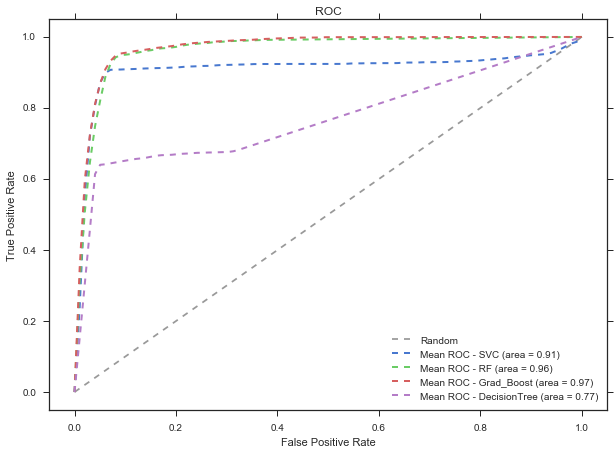

In [64]:
rocPlots(train_X,train_y,classifiers)

In [65]:
# Split further into train and validation set
train_X,valid_X,train_y,valid_y = train_test_split(train_X,train_y,test_size = 0.2, stratify=train_y,random_state=99)

In [66]:
clf_rf = RandomForestClassifier(n_estimators=100, n_jobs=-1) 
clf_rf.fit(train_X,train_y)
confusion_matrix(valid_y,clf_rf.predict(valid_X))

In [69]:
print classification_report(train_y, clf_rf.predict(train_X))

             precision    recall  f1-score   support

          0       0.99      1.00      1.00     31060
          1       0.98      0.95      0.97      3928

avg / total       0.99      0.99      0.99     34988



In [70]:
print classification_report(valid_y,clf_rf.predict(valid_X))

             precision    recall  f1-score   support

          0       0.96      0.96      0.96      7766
          1       0.72      0.71      0.71       982

avg / total       0.94      0.94      0.94      8748



In [71]:
param_grid = {"n_estimators":[10, 50, 100],
              "max_depth": [3, 5, 7, None],
              "max_features": [0.3, "sqrt", "log2"],
              "min_samples_split": [1, 3, 10],
              "min_samples_leaf": [1, 3, 10]}

In [72]:
clf_rf_best = GridSearchCV(RandomForestClassifier(),param_grid=param_grid,n_jobs=-1).fit(train_X,train_y)

In [73]:
print "Classifiction Report: Training data"
pred_train_y = clf_rf_best.best_estimator_.predict(train_X)
print classification_report(train_y, pred_train_y)
print "Classifiction Report: Validation data"
pred_valid_y = clf_rf_best.best_estimator_.predict(valid_X)
print classification_report(valid_y, pred_valid_y)

Classifiction Report: Training data
             precision    recall  f1-score   support

          0       0.98      0.96      0.97     31060
          1       0.73      0.83      0.77      3928

avg / total       0.95      0.95      0.95     34988

Classifiction Report: Validation data
             precision    recall  f1-score   support

          0       0.98      0.96      0.97      7766
          1       0.72      0.81      0.76       982

avg / total       0.95      0.94      0.94      8748



In [74]:
clf_rf_best.best_params_

{'max_depth': 7,
 'max_features': 0.3,
 'min_samples_leaf': 3,
 'min_samples_split': 10,
 'n_estimators': 100}

In [75]:
# Lets test the model against the test data
print "Classifiction Report: Test data"
pred_test_y = clf_rf_best.best_estimator_.predict(test_X)
print classification_report(test_y, pred_test_y)

Classifiction Report: Test data
             precision    recall  f1-score   support

          0       0.98      0.96      0.97      9707
          1       0.72      0.82      0.77      1227

avg / total       0.95      0.94      0.95     10934



(-1, 57)

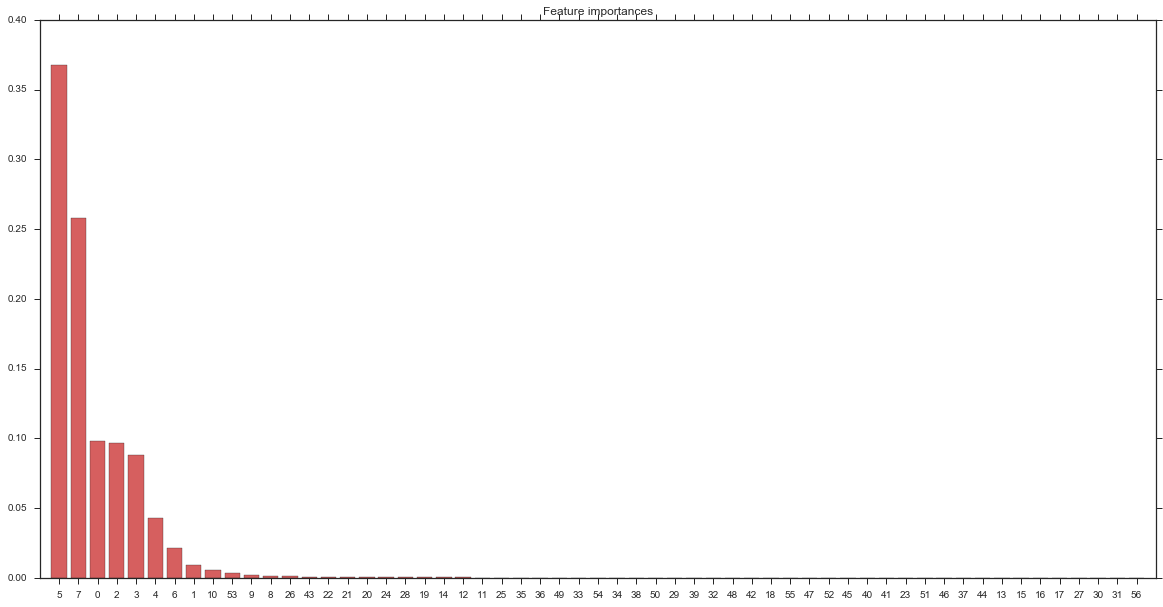

In [76]:
importances = clf_rf_best.best_estimator_.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot the feature importances of the forest
plt.figure(figsize=(20,10))
plt.title("Feature importances")
plt.bar(range(train_X.shape[1]), importances[indices],color="r", align="center")
plt.xticks(range(train_X.shape[1]), indices)
plt.xlim([-1, train_X.shape[1]])

In [77]:
train_X.columns[indices].ravel()

array(['signup_veh_addded_days', 'vehicle_15days', 'vehicle_year',
       'vehicle_details_added', 'ratioXcount', 'signup_bgc_days',
       'bgc_9days', 'Consent_bgc', 'signup_channel_Referral',
       'vehicle_make_Toyota', 'signup_channel_Paid',
       'signup_channel_Organic', 'vehicle_make_Honda',
       'vehicle_make_Nissan', 'vehicle_make_Dodge',
       'vehicle_make_Chrysler', 'vehicle_make_Chevrolet',
       'vehicle_make_Ford', 'vehicle_make_Hyundai',
       'vehicle_make_Cadillac', 'vehicle_make_BMW', 'vehicle_make_Audi',
       'vehicle_make_Acura', 'vehicle_make_GMC', 'vehicle_make_Lexus',
       'vehicle_make_Lincoln', 'vehicle_make_Scion', 'vehicle_make_Kia',
       'vehicle_make_Volkswagen', 'vehicle_make_Land Rover',
       'vehicle_make_Mazda', 'vehicle_make_Subaru',
       'vehicle_make_Infiniti', 'vehicle_make_Mercedes-Benz',
       'vehicle_make_Jeep', 'vehicle_make_Saturn',
       'vehicle_make_Mitsubishi', 'vehicle_make_Buick',
       'vehicle_make_Volvo', 'vehicl